## Evaluating the relationship between Low Birthweight and Poor Air Quality

### Data Organization and Cleaning

- Files were structured for ordinary excel reading, which added difficulty to data handling. 
- The follow methods are used for the purpose of aggregating the data from 12 excel files. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
import sklearn.metrics

- Creates a two index dictionary for traversing data in our main dataframe. 

In [2]:
def create_column_index(df):
    #takes dataframe, and returns a dictionary of replacing each column top 'unnamed' in the first row as it's corresponding category
    #note that column indexes will have two rows, data category and specific statistic
    columns = [x for x in df.columns]
    current = columns[0]
    for i in range(len(columns)):
        if columns[i][:7] == 'Unnamed':
            columns[i] = current
        else:
            current = columns[i]
    column_dict = {x : y for x,y in zip(df.columns,columns)}
    return column_dict

In [3]:
def multi_index(df):
    #creates the multi-index for a given dataframe
    df.rename(columns=create_column_index(df),inplace=True)
    column_names = pd.MultiIndex.from_tuples(zip(df.columns,df.iloc[0,:]))
    df.columns = column_names
    return df

In [4]:
def create_master_df(file_loc,initialize_file):
    #takes file name and location and initializes the empty master datadf
    master_df = pd.read_excel('./{}/{}'.format(file_loc,initialize_file),'Ranked Measure Data')
    master_df = master_df.iloc[0:1]
    master_df.rename(columns={'Unnamed: 0':'FIPS', 'Unnamed: 1': 'State', 'Unnamed: 2' : 'County'}, inplace=True)
    master_df.insert(0,"Year",['Year'], allow_duplicates=True)
    master_df = multi_index(master_df)
    master_df.drop(index=range(0, len(master_df)), inplace=True)
    return master_df

- Brings data into a single dataframe.

In [5]:
def get_frames(file_loc):
    #pulls data out from folder, and labels them as their year
    #output is a dictionary with each datadf, with key as the string of the year that it's from
    output = {}
    for file in os.listdir(file_loc):
        year = file[:4]
        output[year] = pd.read_excel('./{}/{}'.format(file_loc,file),'Ranked Measure Data')
        output[year].rename(columns={'Unnamed: 0':'FIPS', 'Unnamed: 1': 'State', 'Unnamed: 2' : 'County'}, inplace=True)
        
        year_data = ["Year"]+[year for i in range(output[year].shape[0]-1)]
        output[year].insert(0,'Year', year_data, allow_duplicates=True)

    return output

In [6]:
def get_all_columns(data):
    #helper for column_intersection method below
    #returns column names when given a dict full of dataframes
    assert type(data) == dict, 'input must be dictionary'
    output_dict = {}
    for year,df in data.items():
        columns = [x for x in df.columns]
        output_dict[year] = columns
    return output_dict

- There was variability in covered metrics, so this method below ensures that we only pull from columns for which all files have data

In [7]:
def column_intersection(data):
    #called by the populate_master_df method below
    #returns the columns that exist across all of the dataframes
    assert type(data) == dict, 'input must be dictionary'
    column_dictionary = get_all_columns(data)
    output_set = set()
    for year, column_names in column_dictionary.items():
        if len(output_set) == 0:
            output_set = set(column_names)
        else:
            output_set = output_set.intersection(column_names)
    return output_set

- The below method initializes the df that will be used for analysis

In [8]:
def populate_master_df(master_df, file_loc):
    #builds the full dataframe

    data = get_frames(file_loc)
    #pull down the data from each sheet into a dictionary with keys as the string form of the years
    
    for year, frame in data.items():
        data[year] = multi_index(frame)
    #multi-index each frame

    kept_columns = list(column_intersection(data))
    #column intersection, data is a set type 

    master_df = master_df[kept_columns]

    for year, frame in data.items():
        #iterate through each frame that we have

        data[year] = data[year][kept_columns]
        data[year] = data[year].reindex(columns = kept_columns)
        #remove columns that don't exist across all frames

        master_df = pd.concat([master_df,data[year]],ignore_index=True) #, on=master_df.columns
        #consolidate

    return master_df

        

In [9]:
data_folder = 'LBW and Other Data'
init_file_name = '2022 County Health Rankings Data - v1.xlsx'
master_df = create_master_df(data_folder,init_file_name)
master_df = populate_master_df(master_df, data_folder)

- Overview of columns pulled

In [10]:
reorder = [ (                     'Year',                  'Year'),
            (                   'County',                'County'),
            (                    'State',                 'State'),
            ('Poor physical health days',         '95% CI - High'),
		    ('Poor physical health days',          '95% CI - Low'),
            (      'Poor or fair health',         '95% CI - High'),
            (      'Poor or fair health',          '95% CI - Low'),
            (  'Poor mental health days',         '95% CI - High'),
            (  'Poor mental health days',          '95% CI - Low'),
            (            'Adult smoking',         '95% CI - High'),
            (            'Adult smoking',          '95% CI - Low'),
            (            'Adult smoking',             '% Smokers'),
            (            'Adult obesity',         '95% CI - High'),
            (            'Adult obesity',          '95% CI - Low'),
            (          'Low birthweight',         '95% CI - High'),
            (          'Low birthweight',          '95% CI - Low'),
            (          'Low birthweight',            'Unreliable'),
            (      'Children in poverty',         '95% CI - High'),
            (      'Children in poverty',          '95% CI - Low'),
            (      'Children in poverty', '% Children in Poverty'),

            ]

- Removing unwanded labels from the DataFrame

In [11]:
master_df = master_df.reindex(columns=reorder)
master_df = master_df.loc[master_df[('Year','Year')] != 'Year',:]

- Lowercase columns

In [12]:
col_names = list(master_df.columns)
new_col_names = []
for i in col_names:
    new_col_names.append((str(i[0]).lower(),str(i[1]).lower()))
master_df.columns = pd.MultiIndex.from_tuples(new_col_names)

- Scope of project is only California

In [13]:
cali_data = master_df[master_df[('state','state')] == 'California']
cali_data.reset_index(drop=True,inplace=True)

In [14]:
cali_data[('low birthweight','unreliable')].fillna(0,inplace=True)
cali_data[('low birthweight','unreliable')].replace('x',1,inplace=True)

- Convert to numerical data.

In [15]:
for col in cali_data.columns[3:]:
    cali_data[col] = cali_data[col].astype('float32')

C:\Users\Jack Koltermann\AppData\Local\Temp\ipykernel_460\2182449412.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cali_data[col] = cali_data[col].astype('float32')


In [16]:
for col in list(cali_data.columns[3:]):
    cali_data[col].fillna(cali_data[col].mean(),inplace=True)

In [17]:
cali_data['year'] = cali_data['year'].astype('float32')

C:\Users\Jack Koltermann\AppData\Local\Temp\ipykernel_460\3027082188.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cali_data['year'] = cali_data['year'].astype('float32')


#### Converting data into the Sample Means

- Our Data Source, the University of Wisconsin, offered confidence intervals for their data points.
- We can quickly convert these into sample means by taking the average

In [18]:
def verify_ci(col_name):
    if col_name[1][-4:] == 'high' or col_name[1][-3:] == 'low':
        return True
    return False

In [19]:
def organize_column_ci(df):
    organized_ci = {}
    for col in df.columns:
        if verify_ci(col):
            parent_category = col[0]
            child_category = col[1]
            if not parent_category in organized_ci.keys():
                organized_ci[parent_category] = []
                organized_ci[parent_category].append(df[col].values)
            else:
                organized_ci[parent_category].append(df[col].values)
        else:
            continue
    
    return organized_ci

In [20]:
def calc_parent_mean_series(df):
    ci_data = organize_column_ci(df.copy())
    output = {}
    for key, series in ci_data.items():
        series_a = series[0]
        series_b = series[1]
        output[key] = [(x+y)/2 for x,y in zip(series_a,series_b)]
    return output

In [21]:
def add_mean_series(df):
    mean_series = calc_parent_mean_series(df.copy())
    for key,value in mean_series.items():
        df[(key,str(key)+' sample_mean')] = value
    return df

In [22]:
cali_data = add_mean_series(cali_data)

C:\Users\Jack Koltermann\AppData\Local\Temp\ipykernel_460\1922856923.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[(key,str(key)+' sample_mean')] = value
C:\Users\Jack Koltermann\AppData\Local\Temp\ipykernel_460\1922856923.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[(key,str(key)+' sample_mean')] = value
C:\Users\Jack Koltermann\AppData\Local\Temp\ipykernel_460\1922856923.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

In [23]:
cali_data.columns = cali_data.columns.droplevel()

In [24]:
kept_columns = ['year','county']+[x for x in cali_data.columns if x[-11:] == 'sample_mean']

In [25]:
cali_data = cali_data[kept_columns]

In [26]:
cali_data = cali_data[cali_data.county.notna()]

In [27]:
cali_data[cali_data.columns[2:]] = cali_data[cali_data.columns[2:]]/100

#### Pull Air Quality Data into Dataframe 

In [28]:
air_quality_data = pd.concat([pd.read_csv('air_quality_data/{}'.format(file)) for file in os.listdir('air_quality_data')])

#### Filter `air_quality_data` down to only California

In [29]:
# filter for only California 
cali_air_quality = air_quality_data.query('State == "California"').copy()
cali_air_quality = cali_air_quality.query('Year > 2009').copy().sort_values(by=['County','Year'])

In [30]:
cali_air_quality.columns = cali_air_quality.columns.str.lower()

In [31]:
cali_air_quality.drop(columns=['state'],inplace=True)

In [32]:
#dropping Alpine and 2022 data from air quality and social data
cali_data = cali_data.query('county != "Alpine"').query('year < 2022')
cali_air_quality = cali_air_quality.query('county != "Alpine"').query('year < 2022')

In [33]:
social = set(cali_data.county)
ac = set(cali_air_quality.county)
to_drop = list(social.symmetric_difference(ac))

#### Drop Counties not in Both Datasets

In [34]:
for county in to_drop:
    cali_data = cali_data.query('county != "{}"'.format(county))
    cali_air_quality = cali_air_quality.query('county != "{}"'.format(county))

### Regression Testing

In [36]:
analysis_data = cali_data.merge(cali_air_quality,on=['year','county'])

In [37]:
independent_variables = list(cali_air_quality.columns)[3:]
dependent_variables = list(cali_data.columns)[2:]
context_variables = ['county','year']

In [38]:
X = analysis_data[independent_variables]
y = analysis_data['low birthweight sample_mean']

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
model = LinearRegression()
model.fit(X_train,y_train)


LinearRegression()

In [40]:
model.score(X_train,y_train)


0.31314235555717607

In [41]:
model.score(X_test,y_test)


0.3440850480243386

In [42]:
y_preds = model.predict(X_test)
sklearn.metrics.r2_score(y_test,y_preds)

0.3440850480243386

In [46]:
cross_val_score(model, X_train, y_train, cv=2)

array([0.25868157, 0.19269002])

<AxesSubplot: title={'center': 'Variation in LBW Across California'}, xlabel='year', ylabel='low birthweight sample_mean'>

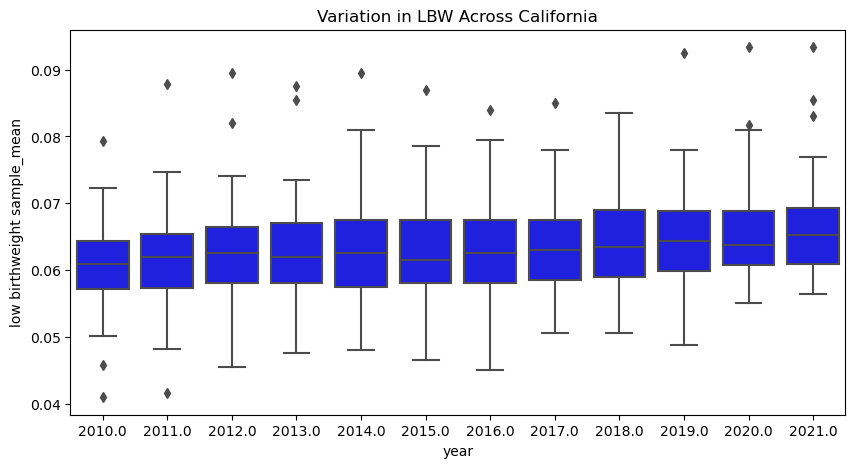

In [104]:
fig, ax1 = plt.subplots(figsize=(10, 5))
plt.title('Variation in LBW Across California')
sns.boxplot(x=analysis_data.year,y=analysis_data['low birthweight sample_mean'], color='blue')

<AxesSubplot: title={'center': 'Variation in Max AQI Scores Across California'}, xlabel='year', ylabel='max aqi'>

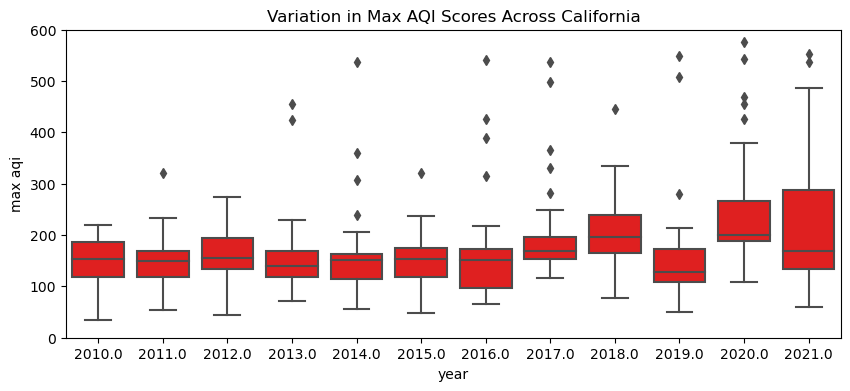

In [100]:
fig, ax1 = plt.subplots(figsize=(10, 4))
plt.title('Variation in Max AQI Scores Across California')
ax1.set_ylim(0,600)
sns.boxplot(x=analysis_data.year,y=analysis_data['max aqi'], color='red')

In [48]:
worst_counties = analysis_data[['county','median aqi']].groupby('county').describe().sort_values(('median aqi','mean'),ascending=False).head(10)

In [49]:
county_focus = worst_counties.index.values

In [50]:
worst_counties_data = analysis_data.query('county in @county_focus')


In [51]:
worst_X = worst_counties_data[independent_variables]

In [52]:
worst_y = worst_counties_data['low birthweight sample_mean']

In [89]:
worst_X.corrwith(worst_y)

good days                             -0.458156
moderate days                         -0.151233
unhealthy for sensitive groups days    0.497614
unhealthy days                         0.488380
very unhealthy days                    0.310512
hazardous days                        -0.152554
max aqi                                0.002753
90th percentile aqi                    0.560876
median aqi                             0.532593
days co                               -0.158854
days no2                               0.078230
days ozone                             0.186555
days pm2.5                             0.245103
days pm10                             -0.508718
dtype: float64

In [90]:
X_train, X_test, y_train, y_test = train_test_split(worst_X, worst_y, test_size=0.33, random_state=42)
model = LinearRegression()
model.fit(X_train,y_train)

LinearRegression()

In [91]:
model.score(X_train,y_train)

0.5014970366844862

In [92]:
model.score(X_test,y_test)

0.40255152313544684

In [93]:
y_preds = model.predict(X_test)
sklearn.metrics.r2_score(y_test,y_preds)

0.40255152313544684

Text(0.5, 1.0, 'Coefficients of Multi-Linear Regression')

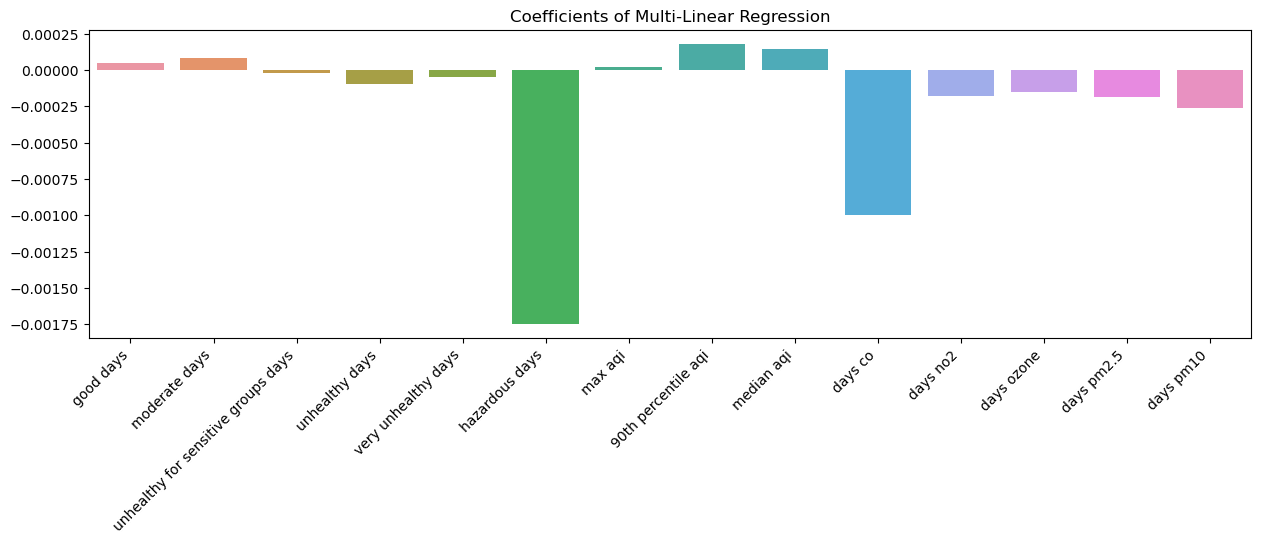

In [99]:
plt.figure(figsize=(15,4))

plt.xticks(rotation=45, ha="right")
sns.barplot(x=worst_X.columns,y=model.coef_)
plt.title('Coefficients of Multi-Linear Regression')

- As seen below, though there are instances across some counties where max AQI shows a very weak relationship with low birthrate variation, there are certainly more variables to consider looking forward

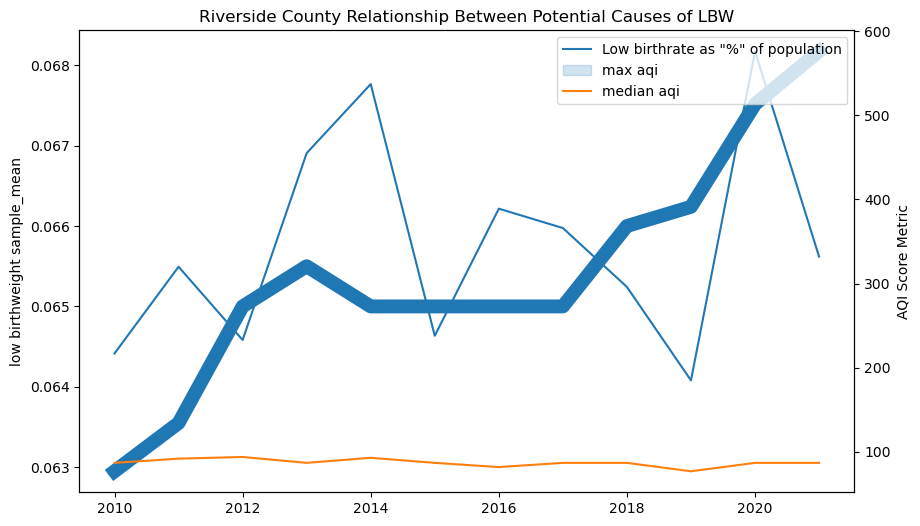

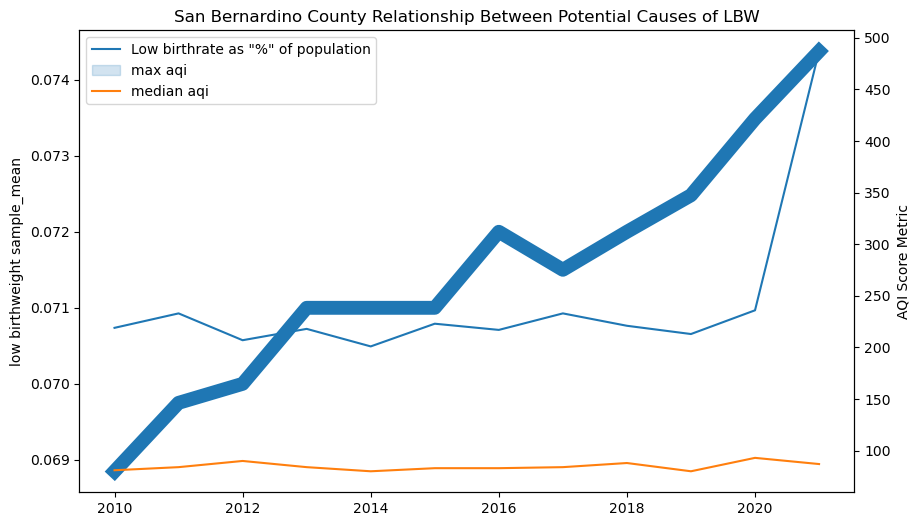

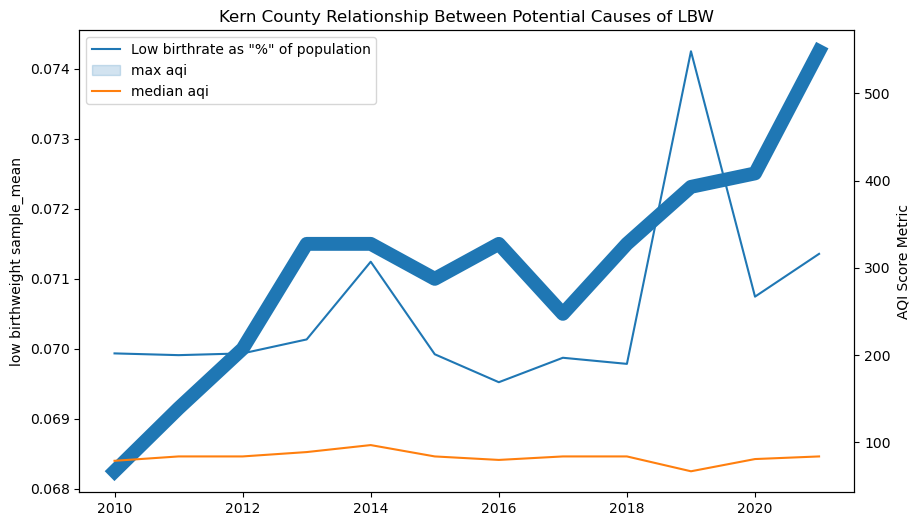

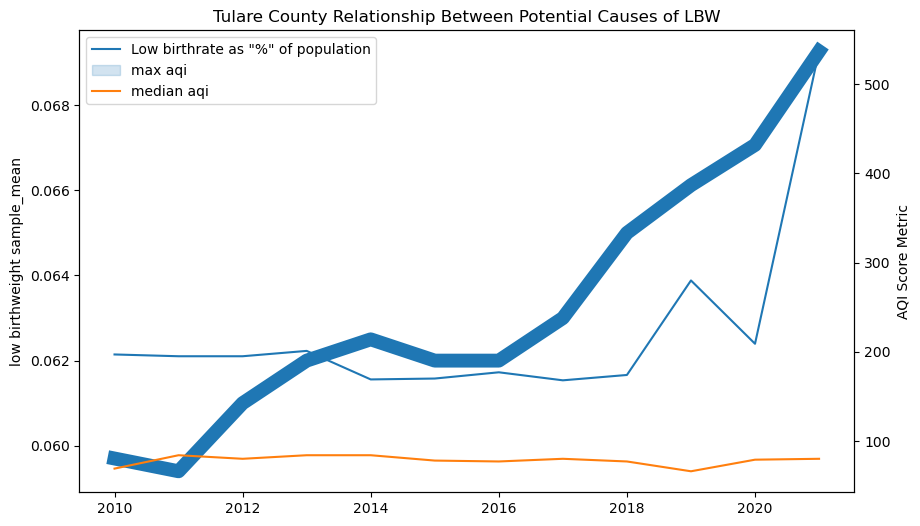

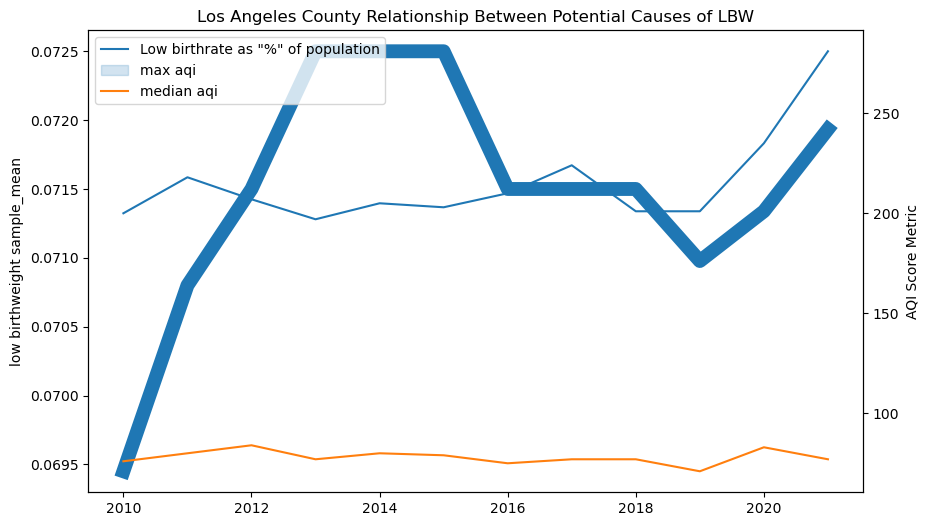

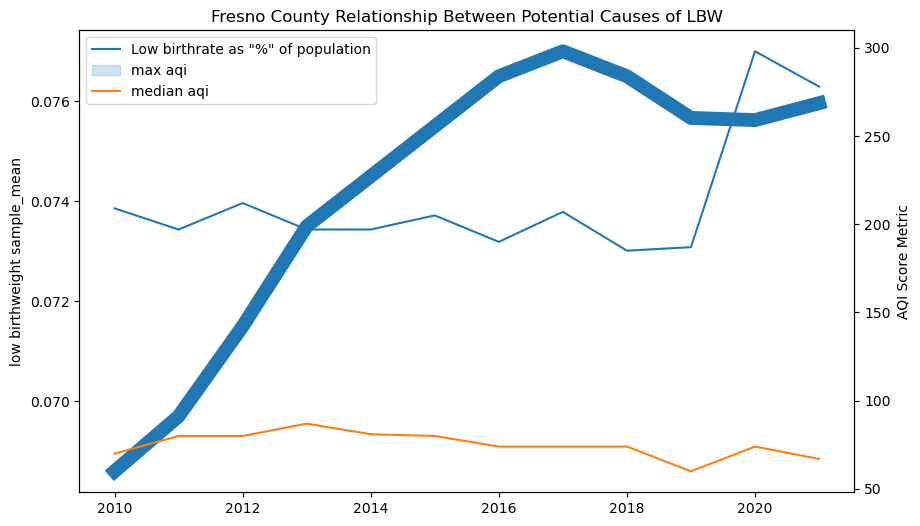

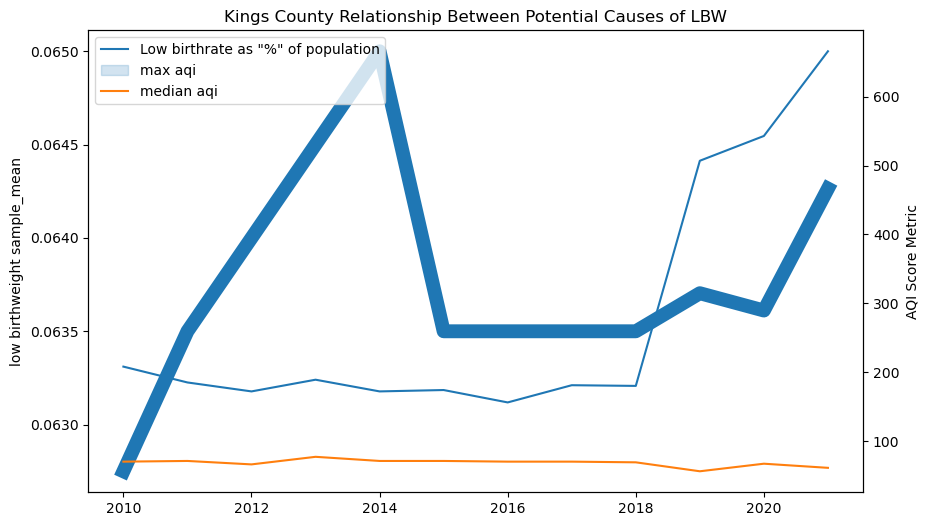

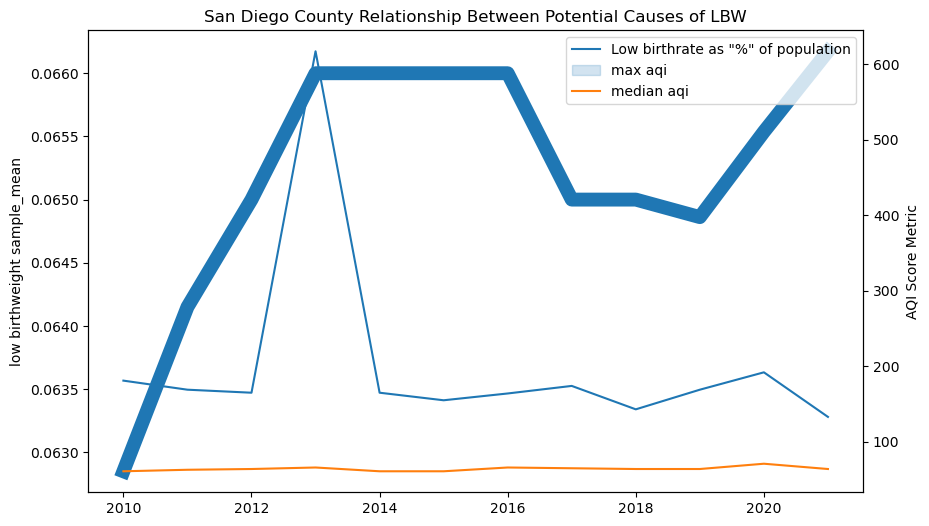

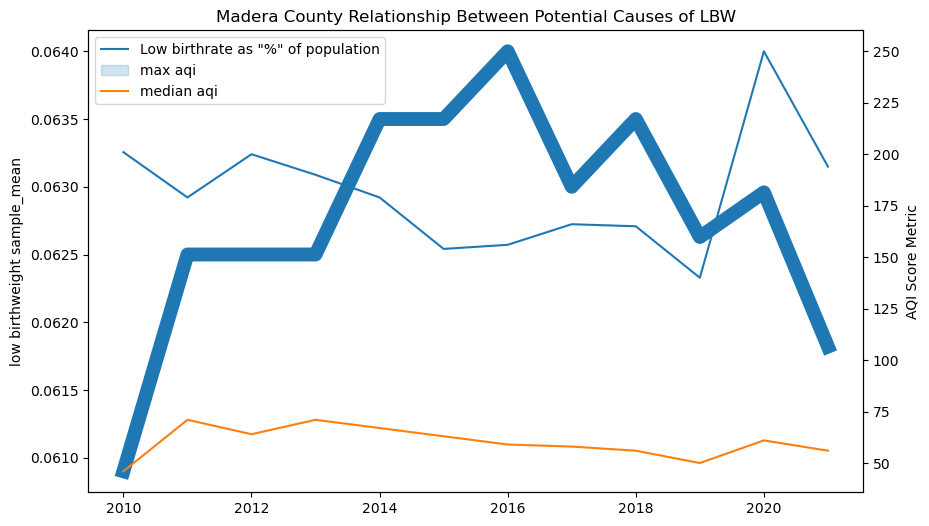

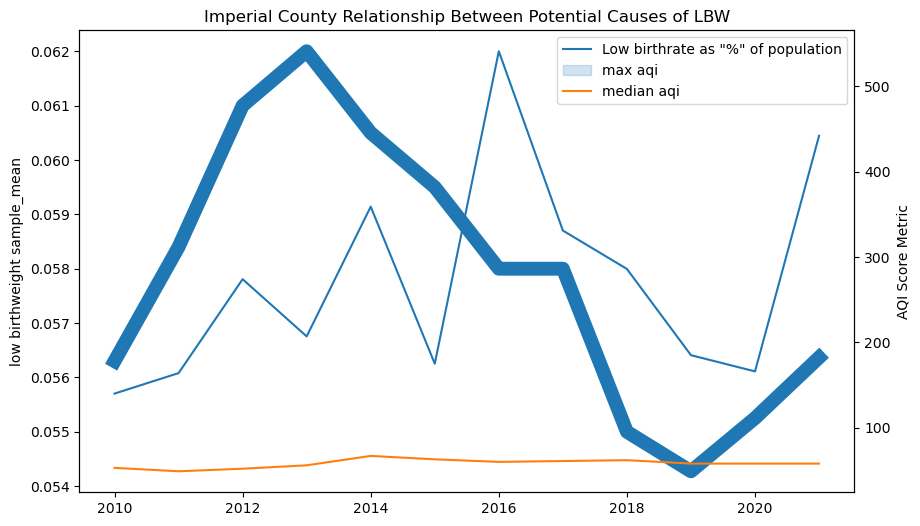

In [105]:
for county in county_focus: 
    lbw_sm = worst_counties_data.loc[worst_counties_data.county == county,'low birthweight sample_mean']
    i_v = worst_counties_data.loc[worst_counties_data.county == county, independent_variables] 
    fig = plt.figure(figsize=(10,6))
    ax1 = fig.add_subplot(111)
    ax2 = ax1.twinx()
    ax2.set_ylabel('AQI Score Metric')

    plt.title('{} County Relationship Between Potential Causes of LBW'.format(county))
    sns.lineplot(x=worst_counties_data.year.unique(),y=lbw_sm,ax=ax1,linewidth=10)
    cnames = []
    for col in ['max aqi','median aqi']:
        sns.lineplot(x=worst_counties_data.year.unique(),y=i_v[col],ax=ax2)
        #plt.set_label(col)
    plt.legend(['Low birthrate as "%" of population', 'max aqi', 'median aqi'])
    plt.show()